<a href="https://colab.research.google.com/github/basselkassem/arabic-ontology/blob/master/policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libs

In [1]:
!pip install import-ipynb

In [2]:
from google.colab import drive
drive.mount("/content/drive", )
%cd /content/drive/'My Drive'/'Colab Notebooks'/easy21

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/easy21


# Import libs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import environment as env
from collections import defaultdict
import pickle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

importing Jupyter notebook from environment.ipynb


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Instructions for updating:
non-resource variables are not supported in the long term
2.2.0-rc4


# Implementation of MonteCarlo Policy Gradient

In [0]:
state_dim = 2
actions_num = 2

In [5]:
states = tf.placeholder('float32', (None, state_dim), name = 'states')
actions = tf.placeholder('int32', shape=(None,), name = 'actions')
cumulative_rewards = tf.placeholder('float32',  name = 'cumulative_rewards')
            
layer = tf.layers.Dense(units = 32, activation = tf.nn.relu, name = 'input', kernel_initializer='glorot_uniform')(states)
layer = tf.layers.Dense(units = 32, activation = tf.nn.relu, name = 'layer1', kernel_initializer='glorot_uniform')(layer)

output = tf.layers.Dense(units = actions_num, name = 'output', kernel_initializer='glorot_uniform')(layer)

sampled_actions = tf.squeeze(tf.multinomial(output, 1)) 
loss_pi = tf.reduce_mean(
        cumulative_rewards * tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=output, labels=actions), name='loss_pi')
optimize = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss = loss_pi,)

def get_actions_proba(state):
    return sampled_actions.eval({states: [state]})

def train_step(_states, _actions, _cumulative_rewards):
    optimize.run({
        states: _states,
        actions: _actions,
        cumulative_rewards: _cumulative_rewards,
    })

Instructions for updating:
Use `tf.random.categorical` instead.


In [0]:
class PolicyGradient:
    def __init__(self, episodes_num):
        self.episodes_num = episodes_num
        self.Q = defaultdict(int) # action-value function
        self.easy21 = env.Environment(mode = 'no_debug')

    def agent_policy(self, state):
        return get_actions_proba(np.array(state))

    def policy_improvement(self, returned_reward, episode):
        states, actions, rewards = [], [], []
        for state, action, reward in episode:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
        train_step(states, actions, reward)

    def policy_evaluation(self, state):
        done = False
        episode = []
        returned_reward = 0
        player_action = self.agent_policy(state)
        while not done:
            state, reward, done = self.easy21.step(state, player_action)
            player_action = self.agent_policy(state)
            returned_reward += reward
            episode.append((state, player_action, returned_reward))
        return returned_reward, episode

    def policy_iteration(self):
        rewards = []
        for episode in np.arange(self.episodes_num):
            self.easy21 = env.Environment(mode = 'no_debug')
            state, _, done = self.easy21.init()
            returned_reward, episode = self.policy_evaluation(state)
            self.policy_improvement(returned_reward, episode)
            rewards.append(returned_reward)
        return rewards

# Visualize Results

In [14]:
%%time
tf_session = tf.InteractiveSession()
tf_session.run(tf.global_variables_initializer())
episodes_num = 1000
agent = PolicyGradient(episodes_num)
rewards = agent.policy_iteration()

CPU times: user 2.19 s, sys: 174 ms, total: 2.37 s
Wall time: 1.91 s


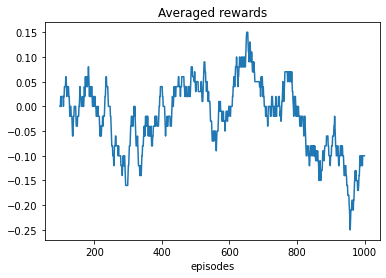

In [15]:
def moving_average(a, n=3) :
    res = np.cumsum(a, dtype=float)
    res[n:] = res[n:] - res[: -n]
    return res[n - 1:] / n
window = episodes_num // 10
res = moving_average(rewards, n = window)
x = np.arange(episodes_num)
plt.plot(x[window - 1:], res)
plt.xlabel('episodes')
plt.title('Averaged rewards')
plt.show()

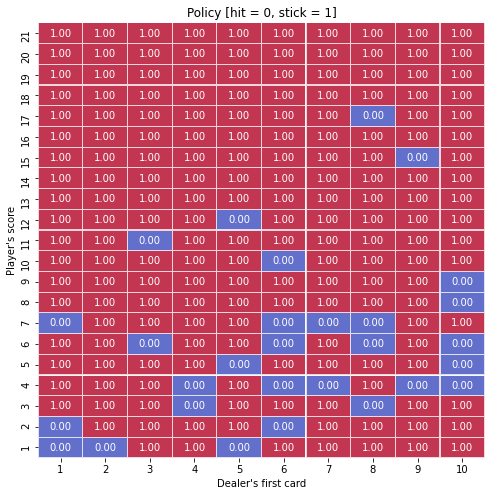

In [16]:
policy = np.zeros((env.MAX_VALUE , env.CARD_VALUE_MAX))
for i in range(1, env.MAX_VALUE + 1):
    for j in range(1, env.CARD_VALUE_MAX + 1):
        state = np.array([j, i])
        policy[i - 1, j - 1] = get_actions_proba(state) #np.argmax(get_actions_proba(state))
        
env.Visualizer.draw2d_array(policy, 'Policy [hit = 0, stick = 1]', True)
tf_session.close()

In [17]:
%%time
tf_session = tf.InteractiveSession()
tf_session.run(tf.global_variables_initializer())

episodes_num = 10000
agent = PolicyGradient(episodes_num)
rewards = agent.policy_iteration()
window = episodes_num // 10

CPU times: user 20.6 s, sys: 1.49 s, total: 22.1 s
Wall time: 17.4 s


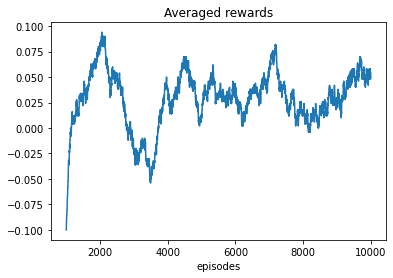

In [18]:
res = moving_average(rewards, n = window)
x = np.arange(episodes_num)
plt.plot(x[window - 1:], res)
plt.xlabel('episodes')
plt.title('Averaged rewards')
plt.show()

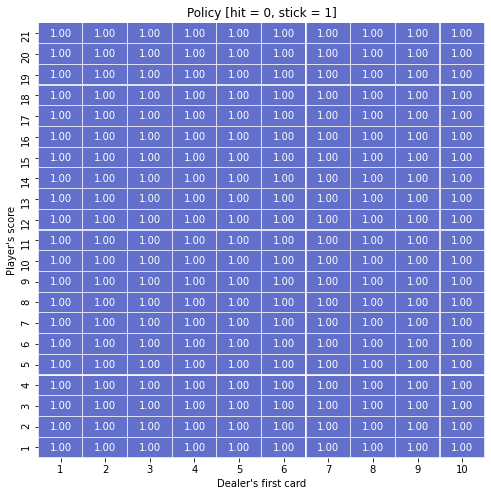

In [19]:
policy = np.zeros((env.MAX_VALUE , env.CARD_VALUE_MAX))
for i in range(1, env.MAX_VALUE + 1):
    for j in range(1, env.CARD_VALUE_MAX + 1):
        state = np.array([j, i])
        policy[i - 1, j - 1] = get_actions_proba(state)
        
env.Visualizer.draw2d_array(policy, 'Policy [hit = 0, stick = 1]', True)
tf_session.close()